## 1.Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read files - Google Drive

In [ ]:
#Conexao com o Google Drive. Pode-se conectar com outras plataformas ou usar dados locais
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados

Mounted at /content/drive
/content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados


Plotagem Histograma das medias mensais das precipitacoes

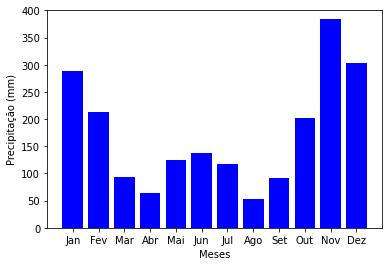

In [ ]:
#Colocar o id da bacia hidrográficas do CABra
id_bacia = 496

#Colocar o caminho (link) dos dados
ec_earth3_ssp585_precipitacao_link = "/content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados/EC-EARTH3-pr-ssp585Basins.csv"

#Lendo as informacoes
ec_earth3_ssp585_precipitacao_dados = pd.read_csv(ec_earth3_ssp585_precipitacao_link,
                  encoding='latin',
                  delimiter=','
                  )

#Filtrando os dados somente para a serie de 30 anos (2070-2100)
filtro = np.logical_and(ec_earth3_ssp585_precipitacao_dados['year'] >= 2070, ec_earth3_ssp585_precipitacao_dados['year'] <= 2100);
ec_earth3_ssp585_precipitacao_dados_2070_2010 = ec_earth3_ssp585_precipitacao_dados[filtro];

#Calculo das medias mensais (2070-2100)
Medias_mensais_bacia =  ec_earth3_ssp585_precipitacao_dados_2070_2010.groupby(['month']).sum()/30

#Meses do ano
meses = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']

#Plotagem
plt.bar(meses, Medias_mensais_bacia[f'CABra_{id_bacia}'], color="blue")
plt.ylim([0.0, 400])
plt.xlabel('Meses')
plt.ylabel('Precipitação (mm)')
plt.show()

Funcoes para o calculo das medias mensais das evapotranspiracoes por Penman-Monteith

ZOTARELLI, Lincoln et al. Step by Step Calculation of the Penman-Monteith Evapotranspiration (FAO-56 Method): reviewed. Florida: Agricultural And Biological Engineering Department IF/IFAS Extension, 2020. 10 p. Disponível em: https://edis.ifas.ufl.edu/pdf/AE/AE45900.pdf. Acesso em: 10 out. 2022.

In [ ]:
#Step 1 – Temperatura média diária
def daily_mean_t(tmin, tmax):
    """
    Estima a temperatura média diária a partir das temperaturas mínimas e máximas diárias.

    :param tmin: Temperatura mínima diária [deg C]
    :param tmax: Temperatura máxima diária [deg C]
    :return: Temperatura média diária [deg C]
    :rtype: float
    """
    return (tmax + tmin) / 2.0

#Step 2 – Velocidade do vento (u2)
#Valor de entrada

#Step 3 - Inclinação da curva de pressão de vapor de saturação (î)
def delta_svp(tmean):
    """
    Estima a inclinação da curva de pressão de vapor de saturação a uma dada temperatura.

    :param tmean: Temperatura média diária [deg C]
    :return: Pressão de vapor de saturação [kPa degC-1]
    :rtype: float
    """
    tmp = 4098 * (0.6108 * np.exp((17.27 * tmean) / (tmean + 237.3)))
    return tmp / np.power((tmean + 237.3), 2)

#Step 4 – Pressão atmosférica (P)
def atm_pressure(altitude):
    """
    Estime a pressão atmosférica a partir da altitude.
    Assumindo 20 graus Celsius para uma atmosfera padrão.
    :param altitude: Elevação/altitude acima do nível do mar [m]
    :return: Pressão atmosférica [kPa]
    :rtype: float
    """
    tmp = (293.0 - (0.0065 * altitude)) / 293.0
    return np.power(tmp, 5.26) * 101.3

#Step 5 – Constante psychrometric
def psy_const(atmos_pres):
    """
    Calcula a constante psicrométrica.
    Nota:Este método assume que o ar está saturado com vapor de água na temperatura mínima diária.
         Esta suposição pode não ser válida em áreas áridas.
    :param atmos_pres: Pressão atmosférica [kPa].
    :return: Constante psychrometric [kPa degC-1].
    :rtype: float
    """
    return 0.000665 * atmos_pres

#Step 6 – Delta Term (DT) (cálculo auxiliar para Termo de Radiação)
def delta_term(psy,delta,u2):
    """
    Calcula o delta Term (DT)
    :param psy: Constante psychrometric [kPa degC-1].
    :param delta: Pressão de vapor de saturação [kPa degC-1]
    :param u2: Velocidade do vento [m s-1].
    :return: Delta Term
    :rtype: float
    """
    return delta/(delta+psy*(1+0.34*u2))

#Step 8 – Psi Term (PT)
def psi_term(psy,delta,u2):
  return psy/(delta+psy*(1+0.34*u2))

#Step 9 – Temperature Term (TT)
def temperature_term(tmean,u2):
  return (900/(tmean+273))*u2

#Step 10 -Mean saturation vapor pressure derived from air temperature(es)
def avp_from_t(t):
    """
    Estimate actual vapour pressure (*ea*) from temperature.
    :param tmin: Daily temperature [deg C]
    :return: Actual vapour pressure [kPa]
    :rtype: float
    """
    return 0.611 * np.exp((17.27 * t) / (t + 237.3))


#Step 11 – Actual vapor pressure (ea) derived from relative humidity
def avp_from_rhmean(svp_tmin, svp_tmax, rh_mean):
    """
    Estimate actual vapour pressure (*ea*) from saturation vapour pressure at
    daily minimum and maximum temperature, and mean relative humidity.
    Based on FAO equation 19 in Allen et al (1998).
    :param svp_tmin: Saturation vapour pressure at daily minimum temperature
        [kPa]. Can be estimated using ``svp_from_t()``.
    :param svp_tmax: Saturation vapour pressure at daily maximum temperature
        [kPa]. Can be estimated using ``svp_from_t()``.
    :param rh_mean: Mean relative humidity [%] (average of RH min and RH max).
    :return: Actual vapour pressure [kPa]
    :rtype: float
    """
    return (rh_mean / 100.0) * ((svp_tmax + svp_tmin) / 2.0)

#Step 12 – Net radiation (Rn)
def  net_rad_equi_of_ETP(net_rad):
  return 0.408*net_rad

Plotagem das medias mensais das evapotranspiracoes por Penman-Monteith

In [ ]:
#Colocar o id da bacia hidrográficas
id_bacia = 1

#Step 1 – Temperatura média diária

#Colocar o caminho (link) dos dados
ec_earth3_ssp585_tasmin_link = "/content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados/EC-EARTH3-tasmin-ssp585Basins.csv"

#Lendo as informacoes e pulando as linhas sem dados
ec_earth3_ssp585_tasmin_dados = pd.read_csv(ec_earth3_ssp585_tasmin_link,
                  encoding='latin',
                  delimiter=','
                  )

#Filtrando os dados somente para a serie de 30 anos (2070-2100)
filtro = np.logical_and(ec_earth3_ssp585_tasmin_dados['year'] >= 2070, ec_earth3_ssp585_tasmin_dados['year'] <= 2100);
ec_earth3_ssp585_tasmin_dados_2070_2010 = ec_earth3_ssp585_tasmin_dados[filtro];

#Colocar o caminho (link) dos dados
ec_earth3_ssp585_tasmax_link = "/content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados/EC-EARTH3-tasmax-ssp585Basins.csv"

#Lendo as informacoes e pulando as linhas sem dados
ec_earth3_ssp585_tasmax_dados = pd.read_csv(ec_earth3_ssp585_tasmax_link,
                  encoding='latin',
                  delimiter=','
                  )

#Filtrando os dados somente para a serie de 30 anos (2070-2100)
filtro = np.logical_and(ec_earth3_ssp585_tasmax_dados['year'] >= 2070, ec_earth3_ssp585_tasmax_dados['year'] <= 2100);
ec_earth3_ssp585_tasmax_dados_2070_2010 = ec_earth3_ssp585_tasmax_dados[filtro];

#Construindo a tabale de saida de dados
COLUNAS = ['time','year','month','dayOfYear','tasmin','tasmax','tas_mean','u2','i','DT','PT',
           'TT','etmin','etmax','rh_mean','ea','Rn','Rng','ETrad','ETwind','ETO']

step_by_step = pd.DataFrame(columns=COLUNAS)

step_by_step['time'] = ec_earth3_ssp585_tasmax_dados_2070_2010['time']
step_by_step['year'] = ec_earth3_ssp585_tasmax_dados_2070_2010['year']
step_by_step['month'] = ec_earth3_ssp585_tasmax_dados_2070_2010['month']
step_by_step['dayOfYear'] = ec_earth3_ssp585_tasmax_dados_2070_2010['dayOfYear']
step_by_step['tasmin'] = ec_earth3_ssp585_tasmin_dados_2070_2010[f'CABra_{id_bacia}']
step_by_step['tasmax'] = ec_earth3_ssp585_tasmax_dados_2070_2010[f'CABra_{id_bacia}']
step_by_step['tas_mean'] = daily_mean_t(step_by_step['tasmin'],step_by_step['tasmax'])

#Step 2 – Velocidade do vento (u2)

#Colocar o caminho (link) dos dados
ec_earth3_ssp585_u2_link = "/content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados/EC-EARTH3-sfcWind-ssp585Basins.csv"

#Lendo as informacoes e pulando as linhas sem dados
ec_earth3_ssp585_u2_dados = pd.read_csv(ec_earth3_ssp585_u2_link,
                  encoding='latin',
                  delimiter=','
                  )

#Filtrando os dados somente para a serie de 30 anos (2070-2100)
filtro = np.logical_and(ec_earth3_ssp585_u2_dados['year'] >= 2070, ec_earth3_ssp585_u2_dados['year'] <= 2100);
ec_earth3_ssp585_u2_dados_2070_2010 = ec_earth3_ssp585_u2_dados[filtro];

step_by_step['u2'] = ec_earth3_ssp585_u2_dados_2070_2010[f'CABra_{id_bacia}']

#Step 3 - Inclinação da curva de pressão de vapor de saturação (î)

step_by_step['i'] = delta_svp(step_by_step['tas_mean'])

#Step 4 – Pressão atmosférica (P)

#Colocar o caminho (link) dos dados
cabra_general_attributes_link = "/content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados/cabra_general_attributes.csv"

#Lendo as informacoes e pulando as linhas sem dados
cabra_general_attributes_dados = pd.read_csv(cabra_general_attributes_link,
                  encoding='latin',
                  delimiter=','
                  )

elev_mean = np.float_(cabra_general_attributes_dados[cabra_general_attributes_dados['CABra ID'] == id_bacia]['elev_mean'].tolist())
atm_press = atm_pressure(elev_mean)

#Step 5 – Constante psychrometric

psy = psy_const(atm_press);

#Step 6 – Delta Term (DT) (cálculo auxiliar para Termo de Radiação)

step_by_step['DT'] = delta_term(psy,step_by_step['i'],step_by_step['u2'])

#Step 8 – Psi Term (PT)
step_by_step['PT'] = psi_term(psy,step_by_step['i'],step_by_step['u2'])

#Step 9 – Temperature Term (TT)
step_by_step['TT'] = temperature_term(step_by_step['tas_mean'],step_by_step['u2'])

#Step 10 -Mean saturation vapor pressure derived from air temperature
step_by_step['etmin'] = avp_from_t(step_by_step['tasmin'])
step_by_step['etmax'] =avp_from_t(step_by_step['tasmax'])

#Step 11 – Actual vapor pressure (ea) derived from relative humidity

#Colocar o caminho (link) dos dados
ec_earth3_ssp585_hur_link = "/content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados/EC-EARTH3-hur-ssp585Basins.csv"

#Lendo as informacoes e pulando as linhas sem dados
ec_earth3_ssp585_hur_dados = pd.read_csv(ec_earth3_ssp585_hur_link,
                  encoding='latin',
                  delimiter=','
                  )

#Filtrando os dados somente para a serie de 30 anos (2070-2100)
filtro = np.logical_and(ec_earth3_ssp585_hur_dados['year'] >= 2070, ec_earth3_ssp585_hur_dados['year'] <= 2100);
ec_earth3_ssp585_hur_dados_2070_2010 = ec_earth3_ssp585_hur_dados[filtro];

step_by_step['rh_mean'] = ec_earth3_ssp585_hur_dados_2070_2010[f'CABra_{id_bacia}']

step_by_step['ea'] = avp_from_rhmean(step_by_step['etmin'], step_by_step['etmax'], step_by_step['rh_mean'])

# #Step 12 – The inverse relative distance Earth-Sun (dr) and solar declination (sd)
# step_by_step['dr'] = inv_rel_dist_earth_sun(step_by_step['dayOfYear'])
# step_by_step['sd'] = sol_dec(step_by_step['dayOfYear'])

# #Step 13 – Conversion of latitude (Æ) in degrees to radians

# latitude_degrees = np.float_(cabra_general_attributes_dados[cabra_general_attributes_dados['CABra ID'] == id_bacia]['latitude'].tolist())
# latitude_CABra_rad = latitude_radians(latitude_degrees)

# #Step 14 - Sunset hour angle (…s)
# step_by_step['sha'] = sunset_hour_angle(latitude_CABra_rad, step_by_step['sd'])

#Step 12 – Net radiation (Rn)

#Colocar o caminho (link) dos dados
ec_earth3_ssp585_rss_link = "/content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados/EC-EARTH3-rss-ssp585Basins.csv"

#Lendo as informacoes e pulando as linhas sem dados
ec_earth3_ssp585_rss_dados = pd.read_csv(ec_earth3_ssp585_rss_link,
                  encoding='latin',
                  delimiter=','
                  )

#Filtrando os dados somente para a serie de 30 anos (2070-2100)
filtro = np.logical_and(ec_earth3_ssp585_rss_dados['year'] >= 2070, ec_earth3_ssp585_rss_dados['year'] <= 2100);
ec_earth3_ssp585_rss_dados_2070_2010 = ec_earth3_ssp585_rss_dados[filtro];

step_by_step['Rn'] = ec_earth3_ssp585_rss_dados_2070_2010[f'CABra_{id_bacia}']

step_by_step['Rng'] = net_rad_equi_of_ETP(step_by_step['Rn'])

#Overall ETo equation

#FS1. Radiation term
step_by_step['ETrad'] = step_by_step['DT']*step_by_step['Rng']

#FS2. Wind term
step_by_step['ETwind'] = step_by_step['PT']*step_by_step['TT']*(((step_by_step['etmin']+step_by_step['etmax'])/2)-step_by_step['ea'])

#Final Reference Evapotranspiration Value
step_by_step['ETO'] = step_by_step['ETrad'] + step_by_step['ETwind']

In [ ]:
step_by_step.head()

,time,year,month,dayOfYear,tasmin,tasmax,tas_mean,u2,i,DT,...,TT,etmin,etmax,rh_mean,ea,Rn,Rng,ETrad,ETwind,ETO
20089,2070-01-01 12:00:00,2070,1,1,24.420308,32.310840,28.365574,0.116891,0.224190,0.765725,...,0.349085,3.061031,4.840519,85.973696,3.396627,11.080652,4.520906,3.461772,0.043587,3.505359
20090,2070-01-02 12:00:00,2070,1,2,24.670333,32.308365,28.489349,0.536366,0.225596,0.743080,...,1.601149,3.107120,4.839843,90.121348,3.580955,12.254812,4.999963,3.715372,0.136567,3.851940
20091,2070-01-03 12:00:00,2070,1,3,24.487498,32.914330,28.700914,0.744942,0.228017,0.733893,...,2.222228,3.073357,5.007666,83.718085,3.382639,14.240485,5.810118,4.264002,0.310413,4.574415
20092,2070-01-04 12:00:00,2070,1,4,24.784125,33.150860,28.967493,0.572335,0.231098,0.745706,...,1.705818,3.128296,5.074531,84.912399,3.482608,13.479805,5.499761,4.101206,0.224699,4.325905
20093,2070-01-05 12:00:00,2070,1,5,24.951661,34.061388,29.506524,0.419624,0.237434,0.759023,...,1.248442,3.159702,5.339216,82.583877,3.509368,14.449843,5.895536,4.474845,0.194853,4.669699


In [ ]:
step_by_step.to_csv('ETO_CABra01_SSP585_2070_2010_v2.csv')